# Machine Learning Group Project
# Character Detection

This notebook contains the whole process of processing the downloaded data to a form that can be used for both training and evaluating our neural network for the classification aspect. Then showing how cv2 contours can be used as the detection aspect, identifying a bounding box containing the character and passing that character to be classified.

### To properly run all cells you can __Mount Drive__ and change directory to where the model, history, 'emnist letters' folder and 'testingImages' folder are! Make sure to download any dependencies that are needed!

In [ ]:
!pwd
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Group16 Submission')
!pwd

/content
/content/drive/My Drive/Colab Notebooks/Group16 Submission


In [ ]:
import os
import cv2
import idx2numpy
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
%matplotlib inline 

from tkinter import *
import tkinter as tk
import tkinter
from PIL import ImageGrab, Image
from IPython.display import Image 

In [ ]:
# !pip install idx2numpy

## Dataset

For our chosen dataset we decided to use the EMNIST Letters Dataset which is a split of the whole EMNIST dataset. It was found from their website https://www.nist.gov/itl/products-and-services/emnist-dataset and downloaded by going to 'Where to Download?'
and clicking to 'Binary format as the __original MNIST dataset__'. Within that zip file we gathered the 4 files which contain the images and labels for the emnist-letters set we wanted and extracted them to a folder called (emnist letters) which is in the same directory as our notebook. Then we access these files and convert them to a numpy representation where they can be further used.

In [ ]:
# Converting to numpy arrays
x_train = idx2numpy.convert_from_file('emnist letters/emnist-letters-train-images-idx3-ubyte')
y_train = idx2numpy.convert_from_file('emnist letters/emnist-letters-train-labels-idx1-ubyte')

x_test = idx2numpy.convert_from_file('emnist letters/emnist-letters-test-images-idx3-ubyte')
y_test = idx2numpy.convert_from_file('emnist letters/emnist-letters-test-labels-idx1-ubyte')

label_map = 'abcdefghijklmnopqrstuvwxyz'

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the images and tranposing them to bring them to the correct orientation.
x_train = (x_train / 255).transpose(0, 2, 1)
x_test = (x_test / 255).transpose(0, 2, 1)

# Subtracting 1 from the labels to correctly bring them to their correct values
y_train = y_train - 1
y_test = y_test - 1
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(124800, 28, 28) (124800,)
(20800, 28, 28) (20800,)


Some image examples


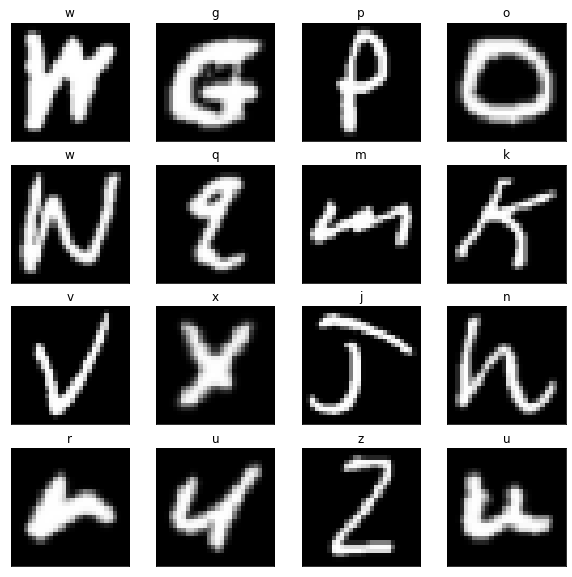

In [ ]:
plt.figure(figsize=(10,10))
print('Some image examples')
# Plotting a small sample of images
for i in range(16): 
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i],cmap='gray')
    plt.title(label_map[y_train[i]])

## Our Deep Learning Model

In [ ]:
class Model_Class:
    def __init__(self, load=True):

        # Initializing variables
        self.image_shape = (28,28)
        self.num_classes = 26
        
        # Choosing of loading the model or creating a new one
        if not os.path.isfile('model.h5') or load==False:
            self.model = self.create_model()
        else:
            self.model = tf.keras.models.load_model('model.h5')        

    def create_model(self):
        
        # Creating the structure of the model of our neural network
        model = Sequential()
        model.add(Flatten(input_shape=self.image_shape))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(256, activation='relu')) 
        model.add(Dropout(0.25))
        model.add(Dense(64, activation='relu'))    
        model.add(Dense(self.num_classes, activation='softmax'))    
        model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
                
        return model

In [ ]:
# Printing the summary structure of the model
print(Model_Class(False).model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 26)                1

In [ ]:
def train_model(load=False):

    model = Model_Class(load).model

    # Checking if they want to load the model from a saved one. If not, a new model is trained
    if load==False:
        # Adapting early stopping method to prevent overfitting
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        
        # Fitting the model and validating with a subset of the trainset
        # Mainting history to plot and observe the metrics during training
        history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[es])
        
        # Saving the trained model
        model.save('model.h5', overwrite=True)
        return model, history

    # If the model was not trained we cannot load its history
    return model, 0

### You can change load to False if you want to train the model from scatch ###
### It can take up to 3 minutes
model, history = train_model(load=True)

Epoch 1/50
1560/1560 [==============================] - 5s 3ms/step - loss: 1.2065 - accuracy: 0.6402 - val_loss: 0.4276 - val_accuracy: 0.8655
Epoch 2/50
1560/1560 [==============================] - 4s 2ms/step - loss: 0.4724 - accuracy: 0.8490 - val_loss: 0.3383 - val_accuracy: 0.8910
Epoch 3/50
1560/1560 [==============================] - 4s 2ms/step - loss: 0.3840 - accuracy: 0.8744 - val_loss: 0.3171 - val_accuracy: 0.8979
Epoch 4/50
1560/1560 [==============================] - 4s 2ms/step - loss: 0.3472 - accuracy: 0.8842 - val_loss: 0.3104 - val_accuracy: 0.8999
Epoch 5/50
1560/1560 [==============================] - 4s 2ms/step - loss: 0.3132 - accuracy: 0.8957 - val_loss: 0.2864 - val_accuracy: 0.9080
Epoch 6/50
1560/1560 [==============================] - 4s 2ms/step - loss: 0.2932 - accuracy: 0.9016 - val_loss: 0.2739 - val_accuracy: 0.9131
Epoch 7/50
1560/1560 [==============================] - 4s 2ms/step - loss: 0.2775 - accuracy: 0.9064 - val_loss: 0.2662 - val_accuracy:

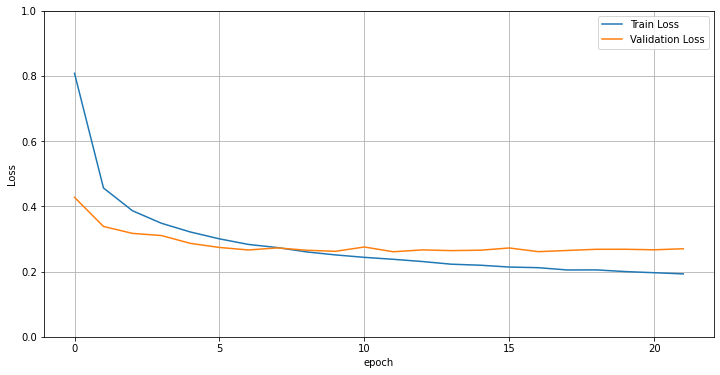

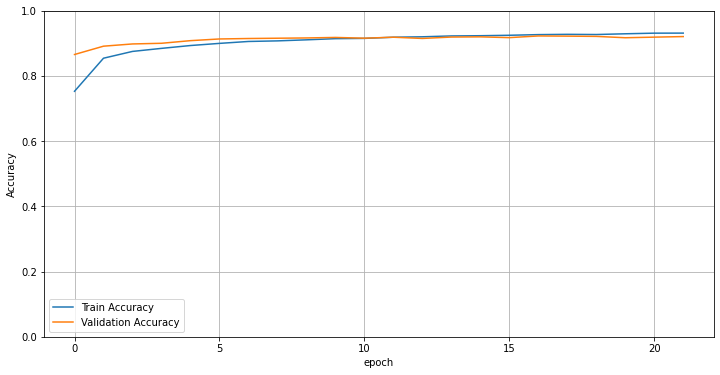

In [ ]:
# Plotting the history
# If you have just loaded the model the history cannot be shown with it.

plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.show()

## Model Evaluation

In [ ]:
# Evaluating the model on the test and train set
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
print('Train Accuracy:', train_accuracy)
print('Train Loss:', train_loss)
print()

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

Train Accuracy: 0.9527323842048645
Train Loss: 0.13594898581504822

Test Accuracy: 0.9197115302085876
Test Loss: 0.2756061553955078


Text(141.0, 0.5, 'Predicted')

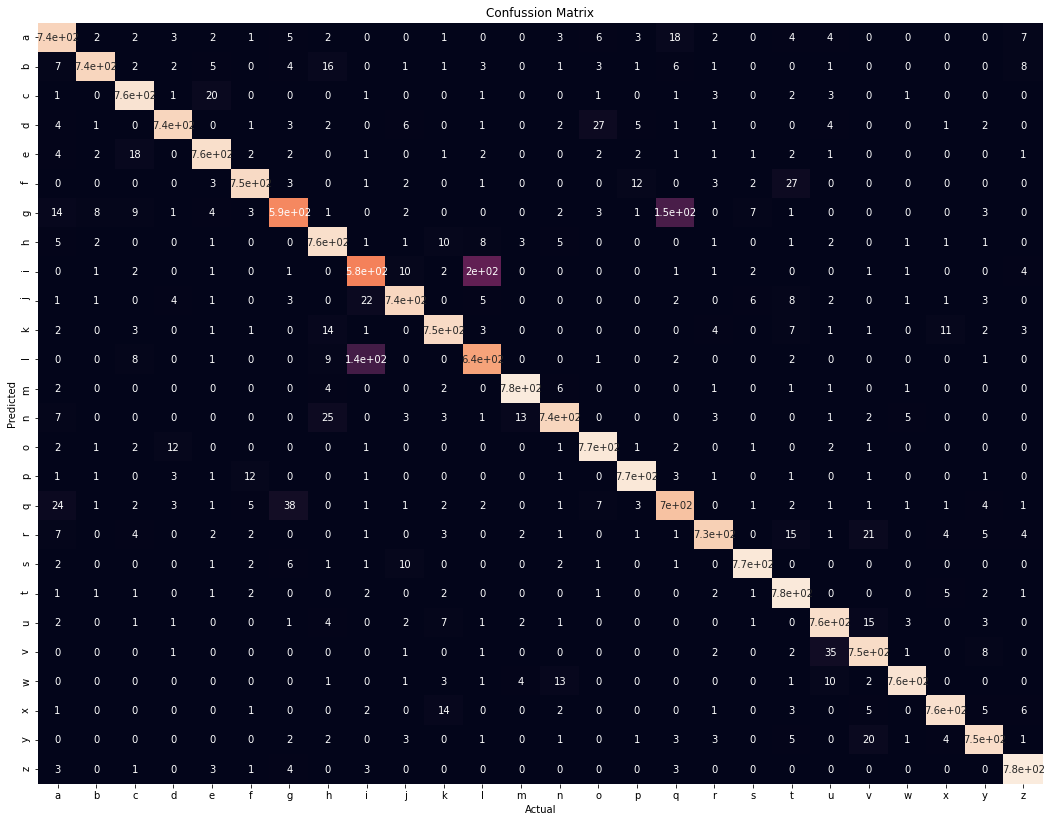

In [ ]:
# Evaluating futher with a confusion matrix
plt.figure(figsize=(18,14))
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
conf_mat = confusion_matrix(y_test, y_pred)

df_conf_mat = pd.DataFrame(conf_mat, index = [i for i in 'abcdefghijklmnopqrstuvwxyz'], columns = [i for i in 'abcdefghijklmnopqrstuvwxyz'])
sns.heatmap(df_conf_mat, annot=True, cbar=False)
plt.title('Confussion Matrix')
plt.xlabel('Actual')
plt.ylabel('Predicted')

## Character detection

To detect the characters within the page we wanted to implement something much simpler. By finding the countours within the image we can extract its bounding boxes where we can then crop and use our classification model to find what character it is

The processing of the cropped characters follows the exact methods that the EMNIST dataset has also used. This can be found in Chapter II, Section C from their paper: https://arxiv.org/pdf/1702.05373v1.pdf

In [ ]:
def character_detection_recognition(folder, image):
    # Reading the filname using the open-cv library but but keeping only 1 channel
    img = cv2.imread(f'{folder}/{image}')[:,:,0]
    img = np.invert(np.array([img]))[0]

    # By filtering with a threhold we can remove any noise from the image which we can then use to find the contours
    # present in the image
    _, threshold = cv2.threshold(img, 100, 255, 0)
    contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for i, cnt in enumerate(contours):
        # We can find the bouding boxes of the detected contours
        (x, y, w, h) = cv2.boundingRect(cnt)
        
        # Filtering for small things such as the small superscript dot of i
        area = cv2.contourArea(cnt)
        if area > 50:
            # Using the bounding box we crop the image to the detected letter
            cropped_img = img.copy()
            cropped_img = cropped_img[y:y+h, x:x+w]

            # Applying a gaussian blur with sigma=1
            cropped_img = cv2.GaussianBlur(cropped_img,(1,1),0)

            height = cropped_img.shape[0]
            width = cropped_img.shape[1]

            # Place into the center of the image and pad with a pixel border of 4
            if height >= width:
                if (height-width) % 2 != 0:
                    cropped_img = cv2.copyMakeBorder(cropped_img,4,4,int(((height-width)/2)+4.5), int(((height-width)/2)+3.5),cv2.BORDER_CONSTANT)
                else:
                    cropped_img = cv2.copyMakeBorder(cropped_img,4,4,int(((height-width)/2)+4), int(((height-width)/2)+4),cv2.BORDER_CONSTANT)
            else:
                if (width-height) % 2 != 0:
                    cropped_img = cv2.copyMakeBorder(cropped_img, int(((width-height)/2)+4.5), int(((width-height)/2)+3.5),4,4,cv2.BORDER_CONSTANT)
                else:
                    cropped_img = cv2.copyMakeBorder(cropped_img,int(((width-height)/2)+4),int(((width-height)/2)+4),4,4,cv2.BORDER_CONSTANT)

            # Normalizing the image
            cropped_img = cropped_img / 255
            # Resizing using a bicubix interpolation method
            cropped_img = cv2.resize(cropped_img, (28, 28), interpolation=cv2.INTER_CUBIC)
            prediction_cropped_img = np.expand_dims(cropped_img, axis=0)
            # Predicting using the processed image
            prediction = model.predict(prediction_cropped_img)
            # Plotting the bounding box and the prediction on the image to be shown
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 1)
            cv2.putText(img, label_map[np.argmax(prediction)], (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)

    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='gray')

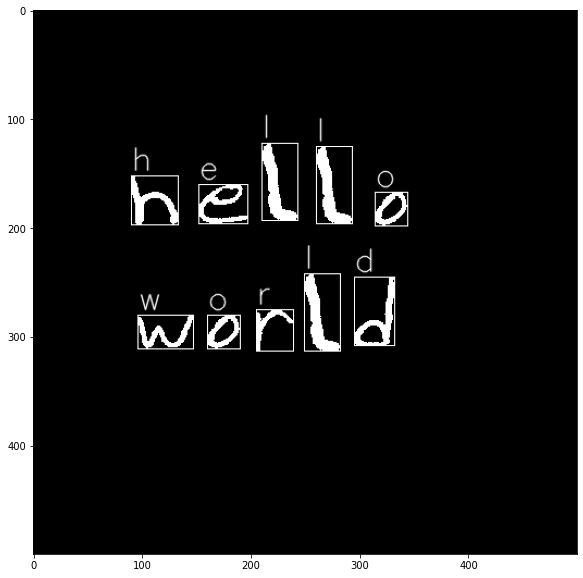

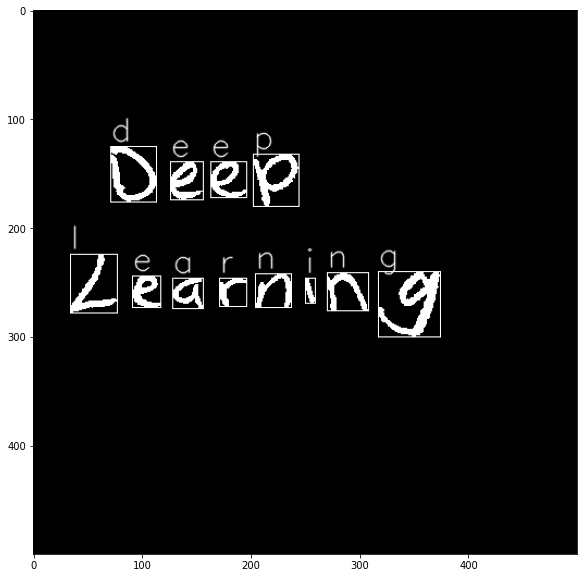

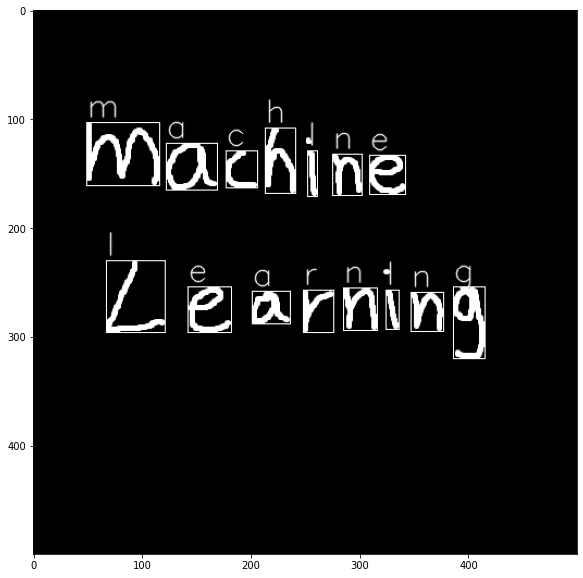

In [ ]:
for image in os.listdir('testingImages'):
    character_detection_recognition('testingImages', image)

## Demo to test on (Only works on Jupyter notebook as google colab does not have an attached display as it only runs our code on a cloud VM)

## We made it easy for you to tranfer and test on anaconda
- You can create a new anaconda environment (python 3.6)
- Use __pip install -r requirements.txt__ after downloading the requirements.txt file
- Move the notebook, emnist letters folder, testingImages folder and the model.h5 
- Uncomment the below cell 
- Comment the first cell that changes directy
- And run notebook again and test the demo

This is based on the code from this hand written digit recognition project https://data-flair.training/blogs/python-deep-learning-project-handwritten-digit-recognition/

In [ ]:
# # For fixing tkinter's issues when using the resolution of the screen when grabbing a screenshot of the canvas
# import ctypes
# ctypes.windll.shcore.SetProcessDpiAwareness(2)

# class App(tk.Tk):
#     def __init__(self):
#         tk.Tk.__init__(self)
#         self.x = self.y = 0
#         # Creating elements
#         self.resizable(False, False)
#         self.canvas = tk.Canvas(self, width=300, height=300, bg = "white", cursor="arrow")
#         self.classify_btn = tk.Button(self, text = "Classify", command = self.classification) 
#         self.button_clear = tk.Button(self, text = "Clear", command = self.clear)
#         # Grid structure
#         self.canvas.grid(row=0, column=0, pady=2, columnspan=2, sticky=tk.W+tk.E)
#         self.classify_btn.grid(row=1, column=0, pady=2)
#         self.button_clear.grid(row=1, column=1, pady=2, padx=40)
#         # Bind
#         self.canvas.bind("<B1-Motion>", self.draw_lines)
    
#     # For drawing the letters
#     def draw_lines(self, event):
#         self.x = event.x
#         self.y = event.y
#         r=1.5
#         self.canvas.create_oval(self.x-r, self.y-r, self.x+r, self.y+r, fill='black')
    
#     # To clear the canvas
#     def clear(self):
#         self.canvas.delete("all")
        
#     def classification(self):
#         x1 = self.canvas.winfo_rootx() * 1.25 + 4
#         x2 = self.canvas.winfo_rootx() * 1.25 - 4 + self.canvas.winfo_width() * 1.25
#         y1 = self.canvas.winfo_rooty() * 1.25 + 4
#         y2 = self.canvas.winfo_rooty() * 1.25 - 4 + self.canvas.winfo_height() * 1.25
#         im = np.array(ImageGrab.grab().crop((x1, y1, x2, y2)))
#         img = im[:,:,0]
#         img = np.invert(np.array([img]))[0]

#         # By filtering with a threhold we can remove any noise from the image which we can then use to find the contours
#         # present in the image
#         _, threshold = cv2.threshold(img, 100, 255, 0)
#         contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         for i, cnt in enumerate(contours):
#             # We can find the bouding boxes of the detected contours
#             (x, y, w, h) = cv2.boundingRect(cnt)

#             # Filtering for small things such as the small superscript dot of i
#             area = cv2.contourArea(cnt)
#             if area > 75:
#                 # Using the bounding box we crop the image to the detected letter
#                 cropped_img = img.copy()
#                 cropped_img = cropped_img[y:y+h, x:x+w]

#                 # Applying a gaussian blur with sigma=1
#                 cropped_img = cv2.GaussianBlur(cropped_img,(1,1),0)

#                 height = cropped_img.shape[0]
#                 width = cropped_img.shape[1]

#                 # Place into the center of the image and pad with a pixel border of 4
#                 if height >= width:
#                     if (height-width) % 2 != 0:
#                         cropped_img = cv2.copyMakeBorder(cropped_img,4,4,int(((height-width)/2)+4.5), int(((height-width)/2)+3.5),cv2.BORDER_CONSTANT)
#                     else:
#                         cropped_img = cv2.copyMakeBorder(cropped_img,4,4,int(((height-width)/2)+4), int(((height-width)/2)+4),cv2.BORDER_CONSTANT)
#                 else:
#                     if (width-height) % 2 != 0:
#                         cropped_img = cv2.copyMakeBorder(cropped_img, int(((width-height)/2)+4.5), int(((width-height)/2)+3.5),4,4,cv2.BORDER_CONSTANT)
#                     else:
#                         cropped_img = cv2.copyMakeBorder(cropped_img,int(((width-height)/2)+4),int(((width-height)/2)+4),4,4,cv2.BORDER_CONSTANT)

#                 # Normalizing the image
#                 cropped_img = cropped_img / 255
#                 # Resizing using a bicubix interpolation method
#                 cropped_img = cv2.resize(cropped_img, (28, 28), interpolation=cv2.INTER_CUBIC)
#                 prediction_cropped_img = np.expand_dims(cropped_img, axis=0)
#                 # Predicting using the processed image
#                 prediction = model.predict(prediction_cropped_img)
#                 # Plotting the bounding box and the prediction on the image to be shown
#                 cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 1)
#                 cv2.putText(img, label_map[np.argmax(prediction)], (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)

#         plt.figure(figsize=(10,10))
#         plt.imshow(img, cmap='gray')
#         plt.show()
    
# App().mainloop()